In [7]:
import numpy as np
import pandas as pd
import seaborn as sns;
sns.set_style("ticks")
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.rcParams['figure.figsize'] = [13, 9]

import csv
from math import log

from scipy import stats
from scipy.stats import norm, laplace
from scipy.stats import kstwobign
from scipy.special import kolmogorov

from sklearn.neighbors import KernelDensity
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn import mixture

import os, io, random
import string

from utils import *

In [5]:
control_from_reads = pd.read_csv('/Volumes/anyaext/NA12878/bc_guppy/batch_1/eventalign_collapsed.tsv/control_5kmer_rna.csv', low_memory=False, index_col=0)
#find_missing_kmers(control_from_reads, 5)
control_from_reads.head()

/opt/anaconda3/envs/asai/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,sample,kmer,logdwell,mean,median
0,NA12878,AGGGA,-3.851869,115.738373,115.537003
1,NA12878,GGGAG,-3.603803,122.975945,123.677002
2,NA12878,GGAGT,-6.066188,110.225075,111.943001
3,NA12878,GAGTC,-3.693289,117.170677,117.223000
4,NA12878,AGTCC,-3.720164,128.738464,132.770996


In [80]:
SAMPLE = 'RNA5'

#df = import_to_df("./tables/out_eventalign_collapse_{}.tsv".format(SAMPLE), SAMPLE)
df = import_to_df('/Volumes/anyaext/var_lib_minknow_data_june2020/data/NRQ3/NRQ3/20191106_0759_MN21875_FAH86111_062cc1d5/mapped/eventalign_collapsed.tsv/out_eventalign_collapse.tsv', 'NRQ3')
df.head()

pos_list = np.sort(df.pos.unique())

Unique reads for NRQ3: 32467


In [74]:
import progressbar

def test_BGMM(df, control):

    print('BGMM test in progress...')
    bgmm = []
    L = len(np.sort(df.pos.unique()))
    bar = progressbar.ProgressBar(maxval=L, \
            widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for pos in range(0, L):
        indx = df['pos'] == pos
        df_indx = df[indx]
        X_ = np.array([np.array(df_indx['median']), np.array(df_indx['logdwell'])])
        X_ = X_.T
        
        kmer = df_indx['kmer'].iloc[0]
        indx = control['kmer'] == kmer
        df_control_indx = control[indx]
        X = np.array([np.array(df_control_indx['median']), np.array(df_control_indx['logdwell'])])
        X = X.T

        estimator = mixture.BayesianGaussianMixture(n_components=2, covariance_type='full', max_iter=1500, tol=0.0001)
        estimator.fit(X)

        p = estimator.score(X_)
        bgmm.append(abs(p))
        
        bar.update(pos+1)
        
    bar.finish()
    return bgmm

BGMM test in progress...


[========================================================================] 100%


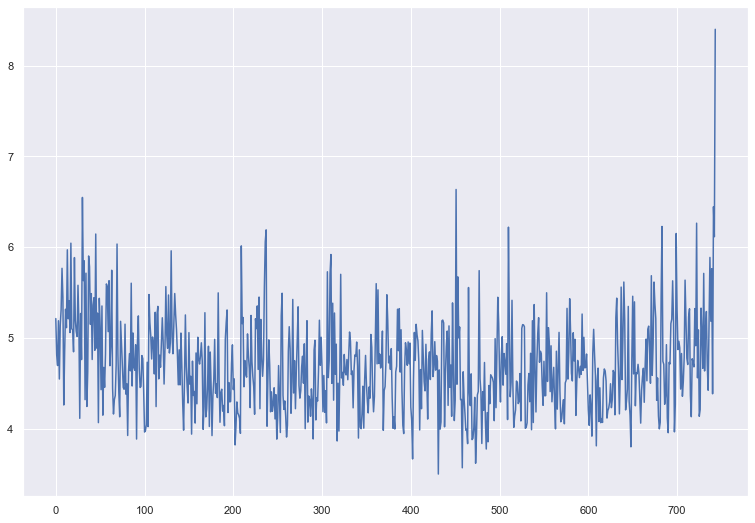

In [78]:
G4_start, G4_width = 579, 18

bgmm = test_BGMM(df, control_from_reads)
plt.plot(bgmm)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((G4_start, 0), G4_width, max(bgmm), facecolor="grey", alpha=0.3))


In [49]:
K = 35

indx = df['pos']==K

df_indx = df[indx]

X_ = np.array([np.array(df_indx['median']), np.array(df_indx['logdwell'])])
X_ = X_.T
estimator_ = mixture.BayesianGaussianMixture(n_components=2, covariance_type='full', max_iter=1500, tol=0.0001)
estimator_.fit(X_)

y_ = estimator.predict(X_)

print(estimator_.weights_)
print(estimator_.means_)
print(np.shape(X_), np.shape(y_))

[0.79136346 0.20863654]
[[88.52705115 -3.72576575]
 [99.6771291  -4.90465011]]
(1848, 2) (1848,)


In [50]:
p_ = estimator_.score(X_)
print(p_)

-4.91568461049232


In [67]:
kmer = df_indx['kmer'].iloc[0]

indx = control_from_reads['kmer'] == kmer
df_control_indx = control_from_reads[indx]

X = np.array([np.array(df_control_indx['median']), np.array(df_control_indx['logdwell'])])
X = X.T

estimator = mixture.BayesianGaussianMixture(n_components=2, covariance_type='full', max_iter=1500, tol=0.0001)
estimator.fit(X)
y = estimator.predict(X)

print(estimator.weights_)
print(estimator.means_)
print(np.shape(X), np.shape(y))

p = estimator.score(X)
print(p)

[0.4938388 0.5061612]
[[84.29264176 -4.57203867]
 [96.54815755 -4.76562038]]
(26553, 2) (26553,)
-4.698690588361073


In [68]:
p = estimator.score(X_)
print(p)

-5.5753127095274095


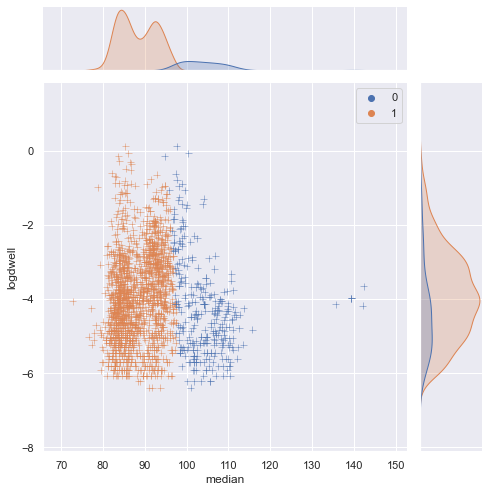

In [65]:
axs = sns.jointplot(x='median', y='logdwell', data=df_indx, kind="scatter", hue=y_, 
                    marker='+', height=7, alpha=0.8, s=50)

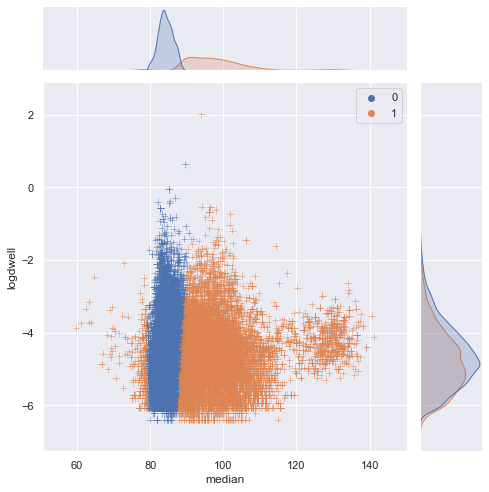

In [69]:
axs = sns.jointplot(x='median', y='logdwell', data=df_control_indx, kind="scatter", hue=y, 
                    marker='+', height=7, alpha=0.8, s=50)

In [47]:
df_indx.head()

,kmer,pos,logdwell,mean,median
13,GGGTC,24,-5.014643,115.193344,114.710495
59,GGGTC,24,-3.112716,120.403320,120.994507
168,GGGTC,24,-2.993136,117.077682,117.720001
264,GGGTC,24,-5.177871,113.540825,113.348999
436,GGGTC,24,-4.791500,118.693222,119.889999


In [48]:
df_control_indx.head()

,sample,kmer,logdwell,mean,median
251929,NA12878,GGGTC,-4.752511,113.956039,115.132004
269295,NA12878,GGGTC,-4.714985,112.218819,112.213997
270134,NA12878,GGGTC,-3.776182,115.021881,115.682999
270546,NA12878,GGGTC,-3.467337,78.029327,75.621696
270872,NA12878,GGGTC,-5.444500,81.643768,79.556396


In [ ]:
import matplotlib as mpl

def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(means[n], eig_vals[0], eig_vals[1],
                                  180 + angle, edgecolor='black')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n]-0.1)
        ell.set_facecolor('#56B4E9')
        ax.add_artist(ell)

In [17]:
df_control_indx.head()

,sample,kmer,logdwell,mean,median
251928,NA12878,TGGGT,-3.033850,111.960495,111.469002
269294,NA12878,TGGGT,-4.714985,105.301430,106.087997
269785,NA12878,TGGGT,-3.867528,117.590370,118.163002
270133,NA12878,TGGGT,-5.812482,106.476219,106.815002
270871,NA12878,TGGGT,-4.642872,67.200302,66.938301
